In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt

## Importing the MNIST dataset

based on the following pytorch excercise by Udacity: (Lesson 5.9 of [this](https://www.udacity.com/course/deep-learning-pytorch--ud188) course)

    Part 3 - Training Neural Networks (Exercises)


In [3]:
# define a transform 
# for this we need to convert the input to torch-tensors using transforms.ToTensor()
# we will be working with MNIST dataset which are gray scale images
# V.Imp: Since the MNIST images have a  single channel, therefore one might be tempted to 
# call transforms.Normalize((0.5), (0.5)) instead of transforms.Normalize((0.5,), (0.5,))
# The difference is the presence of a comma after 0.5 in the second call
# then this will throw an error "too many indices for tensor of dimension 0"
# this is because transforms.Normalize wants a tuple to be passed as its mean and standard
# however torch interprets (0.5) as a number and NOT a tuple. So we need to pass (0.5, )
# This is well explained by Berriel in the following stackoverflow post
# https://stackoverflow.com/questions/56745486/pytorch-dataloader-indexerror-too-many-indices-for-tensor-of-dimension-0

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5, ))]) 

# import the MNIST dataset
train = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = True, transform = transform)
# Dataloader
trainloader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = True)

Each image has shape: (28, 28)


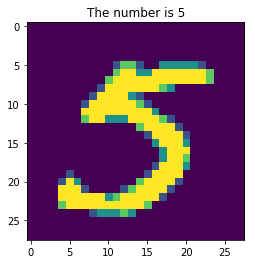

In [4]:
# checkout a random image in the training set
image, label = next(iter(trainloader))
img=torch.squeeze(image[0],0).numpy()
print('Each image has shape: {}'.format(img.shape))
plt.figure()
plt.imshow(img)
plt.title("The number is {}".format(label[0]))
plt.show()

## Defining a simple CNN 

In [5]:
# model architechture:
# 1st Conv. layer with 4 filters; Each having a kernel of size 3, stride = 1, and default padding and dilation
# this will reduce the shape of the input tensor from (1,28,28) to (4,26,26)
# then apply Relu activation
# 2nd Conv. layer with 2 filters, each having a kernel size 5, stride = 1, default padding and dilation
# the output of this layer will have shape (2, 22, 22)
# again apply ReLU to this output
# Now flatten the output to pass to a linear NN for classification
# The output of this layer will be a 1d array of 2*22*22 = 968 elements
# We now add a linear layer of 32 nuerons

# the model has to be a class that inherits from nn.Module
# note that we can define relu once and use it repeatedly. Also see the following discussion
# https://discuss.pytorch.org/t/using-same-dropout-object-for-multiple-drop-out-layers/39027
class my_CNN(nn.Module):
    # class constructor (i.e. initializer)
    def __init__(self):
        # initialize the base class
        super().__init__()
        
        self.l1 = nn.Conv2d(1, 4, 3 )
        
        self.relu = nn.ReLU()
        
        self.l2 = nn.Conv2d(4, 2, 5 )
        
        self.flatten = nn.Flatten()
        
        self.l3 = nn.Linear(968, 32, bias = True)
        
        self.l4 = nn.Linear(32, 10, bias = True)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out1 = self.l1(x)
        act1 = self.relu(out1)
        out2 = self.l2(act1)
        act2 = self.relu(out2)
        flat = self.flatten(act2)
        out3 = self.l3(flat)
        act3 = self.relu(out3)
        out4 = self.l4(act3)
        
        output = self.softmax(out4)
        
        return output
        
        
        
        

In [6]:
model = my_CNN()
model

my_CNN(
  (l1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (l2): Conv2d(4, 2, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten()
  (l3): Linear(in_features=968, out_features=32, bias=True)
  (l4): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [7]:
out = model(image)

In [8]:
out.shape

torch.Size([128, 10])

In [9]:
# defining loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
# training
epochs = 1
losses = []
for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        optimizer.zero_grad()
        predprob = model(images)
        loss = criterion(predprob, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
    
    losses.append(running_loss/len(trainloader)) # this is the average loss per batch
    print('average loss per batch at the end of epoch: {} is {}'.format(epoch, losses[-1]))              
    

average loss per batch at the end of epoch: 0 is -0.7860823079212896


model prediction: 9
image label: 9


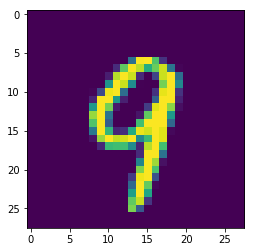

In [11]:
# verify model predictions
images, labels = next(iter(trainloader))
with torch.no_grad():
    preds = model(images)

    img = torch.squeeze(images[0]).numpy()
    prd = torch.argmax(preds[0]).item()
    lbl = labels[0].item()
    print('model prediction: {}'.format(prd))
    print('image label: {}'.format(lbl))
    plt.figure()
    plt.imshow(img)
    plt.show()

In [13]:
# visualizing CNN features
# see https://discuss.pytorch.org/t/visualize-feature-map/29597/2
# and https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
activation = {}
def get_activation(name):
    def hook(m, i , o):
        activation[name] = o.detach()
    
    return hook


model.l1.register_forward_hook(get_activation('l1'))
img, label = train[0]
img.unsqueeze_(0) # input to the model is a 4d tensor with the zeroth axis being the batch index
                  # we therefore need to unsqueeze to reshape our image into a 4d tensor
print(img.shape)
output = model(img)

torch.Size([1, 1, 28, 28])


In [15]:
activation['l1'].shape

torch.Size([1, 4, 26, 26])

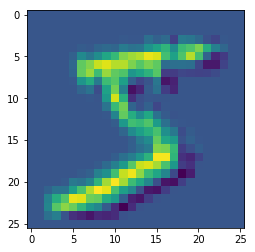

In [23]:
plt.imshow(activation['l1'][0,1].numpy())